In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Plot_MRIO

/content/drive/MyDrive/Plot_MRIO


In [3]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import string
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(20,9)
mpl.style.use('ggplot')

In [ ]:
# Summation of the value insde a dictionary
def dictsum(myDict):
    sum = 0
    for i in myDict:
        sum = sum + myDict[i]
    return sum

In [ ]:
gtap_corresponding = pd.read_excel('First_review_data/World_name.xlsx', sheet_name='gtap')

In [ ]:
gtap_corresponding.columns = ['sectors','Sector Description']
# Set index of gtap_corresponding to "Gtap sector"
gtap_corresponding_indexed = gtap_corresponding.set_index("sectors")

# 1. GTAP

In [ ]:
#@title Read files
# population
file = open("Data/Total_pop_gtap.json", "r")
population_gtap = file.read()
population_gtap = json.loads(population_gtap)

con_mort_tol_gtap = pd.read_csv('First_review_data/S3.csv',index_col=0)
con_mort_tol_gtap = {col: con_mort_tol_gtap[col].to_dict() for col in con_mort_tol_gtap.columns}

# Row sum: total deaths happen in that country
con_total_gtap = dict(pd.DataFrame(con_mort_tol_gtap).sum(axis = 1))

# Col sum: total deaths caused by that country
con_caused_gtap = dict(pd.DataFrame(con_mort_tol_gtap).sum(axis = 0))

file = open("Data/final_demand_gtap.json", "r")
final_demand_gtap = file.read()
final_demand_gtap = json.loads(final_demand_gtap)

# GTAP is in 1000000 USD
for i in final_demand_gtap:
    final_demand_gtap[i] = final_demand_gtap[i] * 1000000

demand_capita_gtap = {}
for country in population_gtap:
    if population_gtap[country] == 0:
        demand_capita_gtap[country] = 0
    else:
        demand_capita_gtap[country] = final_demand_gtap[country] / population_gtap[country]

Gtap_regions = {'PRI':['PRI'],
               'XCB':['AIA','ATG','ABW','BHS','BRB','VGB','CYM','CUB','DMA','GRD','HTI','MSR','KNA','LCA','VCT','TCA','VIR'],
               'XCF':['CAF','TCD','COG','GNQ','GAB','STP'],
               'XEC':['BDI','COM','DJI','ERI','SYC','SOM','SDN'], # gtap ONLY contains Sudan, without South Sudan
               'XER':['AND','BIH','GIB','GGY','VAT','IMN','JEY','MKD','MCO','MNE','SMR','SRB'],
               'XNA':['BMU','GRL','SPM'],
               'XNF':['DZA','LBY','SAH','ESH'], # 'SAH' is changed from 'ESH': Western Sahara
               'XOC':['ASM','COK','FJI','PYF','GUM','KIR','MHL','FSM','NRU','NCL','NIU','MNP','PLW','PNG','PCN','WSM','SLB',
                      'TON','TUV','VUT','WLF'], #'TKL' Tokelau is removed since it's counted as New Zealand
               'XSE':['MMR','TLS'],
               'XSM':['FLK','GUY','SUR'],
               'XWF':['CPV','GMB','GNB','LBR','MLI','MRT','NER','SHN','SLE'],
               'XAC':['AGO','COD'],
               'XEA':['PRK','MAC'],
               'XSA':['AFG','BTN','MDV'],
               'XSC':['LSO','SWZ'],
               'XSU':['TJK','TKM','UZB'],
               'XWS':['IRQ','LBN','PSX','YEM','SYR'],
               'XEF':['ISL','LIE'],
               'XCA':['BLZ'],
               'XEE':['MDA']}
                #XTW # the rest of the world

In [ ]:
#@title 1.1 Calculation 1: Fraction of deaths caused by foreign demand and occur in the current country
# deaths happen in that country caused by foreign demand
death_by_allforeigndemand_gtap = {} # deaths caused by all foreign demand
death_by_G50foreigndemand_gtap = {} # deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
death_by_G100foreigndemand_gtap = {} # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
for i in demand_capita_gtap:
    death_by_allforeigndemand_gtap[i] = 0
    death_by_G50foreigndemand_gtap[i] = 0
    death_by_G100foreigndemand_gtap[i] = 0
    for j in demand_capita_gtap:
        if i != j:
            death_by_allforeigndemand_gtap[i] += con_mort_tol_gtap[j][i] # deaths caused by j and happen in i

            if demand_capita_gtap[j] >= 1.5 * demand_capita_gtap[i]:
                death_by_G50foreigndemand_gtap[i] += con_mort_tol_gtap[j][i]

            if demand_capita_gtap[j] >= 2 * demand_capita_gtap[i]:
                death_by_G100foreigndemand_gtap[i] += con_mort_tol_gtap[j][i]

# total deaths happen in that country
con_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_dom_world_gtap[country] = {}
    con_dom_world_gtap[country]['domestic'] = con_mort_tol_gtap[country][country]
    con_dom_world_gtap[country]['world'] = con_total_gtap[country]
    con_dom_world_gtap[country]['OtherPartofWorld'] = con_dom_world_gtap[country]['world'] - con_dom_world_gtap[country]['domestic']

# total deaths happen in that country RATIO
allforeign_world_gtap = {}
G50foreign_world_gtap = {}
G100foreign_world_gtap = {}
for country in con_dom_world_gtap:
    if con_dom_world_gtap[country]['world'] != 0:
        allforeign_world_gtap[country] = death_by_allforeigndemand_gtap[country] / con_dom_world_gtap[country]['world']
        G50foreign_world_gtap[country] = death_by_G50foreigndemand_gtap[country] / con_dom_world_gtap[country]['world']
        G100foreign_world_gtap[country] = death_by_G100foreigndemand_gtap[country] / con_dom_world_gtap[country]['world']
    else:
        allforeign_world_gtap[country] = 0
        G50foreign_world_gtap[country] = 0
        G100foreign_world_gtap[country] = 0

In [ ]:
#@title 1.2 Calculation 2: Fraction of deaths caused by consumption in this country that occur in other countries
# deaths caused by this country and happen in foreign country
death_allforeign_gtap = {} # deaths caused by consumption in this country that occur in ALL other countries
death_L30foreigndemand_gtap = {} # deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
death_L50foreigndemand_gtap = {} # deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country

for i in con_mort_tol_gtap:
    death_allforeign_gtap[i] = 0
    death_L30foreigndemand_gtap[i] = 0
    death_L50foreigndemand_gtap[i] = 0
    for j in con_mort_tol_gtap:
        if i != j:
            death_allforeign_gtap[i] += con_mort_tol_gtap[i][j] # deaths caused by i and happen in j

            if demand_capita_gtap[j] <= 0.7 * demand_capita_gtap[i]:
                death_L30foreigndemand_gtap[i] += con_mort_tol_gtap[i][j]

            if demand_capita_gtap[j] <= 0.5 * demand_capita_gtap[i]:
                death_L50foreigndemand_gtap[i] += con_mort_tol_gtap[i][j]

# total deaths caused by that country
con_cause_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_cause_dom_world_gtap[country] = {}
    con_cause_dom_world_gtap[country]['domestic'] = con_mort_tol_gtap[country][country]
    con_cause_dom_world_gtap[country]['world'] = con_caused_gtap[country]
    con_cause_dom_world_gtap[country]['OtherPartofWorld'] = con_cause_dom_world_gtap[country]['world'] - con_cause_dom_world_gtap[country]['domestic']

# total deaths caused by that country RATIO
cause_allforeign_world_gtap = {}
cause_L30foreign_world_gtap = {}
cause_L50foreign_world_gtap = {}
for country in con_cause_dom_world_gtap:
    if con_cause_dom_world_gtap[country]['world'] != 0:
        cause_allforeign_world_gtap[country] = death_allforeign_gtap[country] / con_cause_dom_world_gtap[country]['world']
        cause_L30foreign_world_gtap[country] = death_L30foreigndemand_gtap[country] / con_cause_dom_world_gtap[country]['world']
        cause_L50foreign_world_gtap[country] = death_L50foreigndemand_gtap[country] / con_cause_dom_world_gtap[country]['world']
    else:
        cause_allforeign_world_gtap[country] = 0
        cause_L30foreign_world_gtap[country] = 0
        cause_L50foreign_world_gtap[country] = 0

In [ ]:
#@title 1.3 Calculation 3: Net export of deaths
# Row sum: total deaths happen in that country
con_total_gtap = dict(pd.DataFrame(con_mort_tol_gtap).sum(axis=1))

# Col sum: total deaths caused by that country
con_caused_gtap = dict(pd.DataFrame(con_mort_tol_gtap).sum(axis=0))

# total deaths happen in that country
con_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_dom_world_gtap[country] = {}
    con_dom_world_gtap[country]['domestic'] = float(con_mort_tol_gtap[country][country])
    con_dom_world_gtap[country]['world'] = float(con_total_gtap[country])
    con_dom_world_gtap[country]['OtherPartofWorld'] = con_dom_world_gtap[country]['world'] - con_dom_world_gtap[country]['domestic']

# total deaths caused by that country
con_cause_dom_world_gtap = {}
for country in con_mort_tol_gtap:
    con_cause_dom_world_gtap[country] = {}
    con_cause_dom_world_gtap[country]['domestic'] = float(con_mort_tol_gtap[country][country])
    con_cause_dom_world_gtap[country]['world'] = float(con_caused_gtap[country])
    con_cause_dom_world_gtap[country]['OtherPartofWorld'] = con_cause_dom_world_gtap[country]['world'] - con_cause_dom_world_gtap[country]['domestic']

net_export_death_gtap = {}
export_of_death_gtap = {}
import_of_death_gtap = {}

for country in con_cause_dom_world_gtap:
  # net export of deaths
  net_export_death_gtap[country] = (con_cause_dom_world_gtap[country]['OtherPartofWorld'] - con_dom_world_gtap[country]['OtherPartofWorld'])


net_export_death_per_gtap = {} # per population

for country in con_cause_dom_world_gtap:
  if country != 'XTW':
    net_export_val_gtap = (con_cause_dom_world_gtap[country]['OtherPartofWorld'] - con_dom_world_gtap[country]['OtherPartofWorld'])/(population_gtap[country]/10000)
    net_export_death_per_gtap[country] = net_export_val_gtap
  else:
    net_export_death_per_gtap[country] = 0

In [ ]:
# reorder the dependent variables so that their sequence can confirm with the output fracton matrix
allforeign_world_gtap = list({k: allforeign_world_gtap[k] for k in final_demand_gtap}.values())
G50foreign_world_gtap =  list({k: G50foreign_world_gtap[k] for k in final_demand_gtap}.values())
G100foreign_world_gtap =  list({k: G100foreign_world_gtap[k] for k in final_demand_gtap}.values())

cause_allforeign_world_gtap =  list({k: cause_allforeign_world_gtap[k] for k in final_demand_gtap}.values())
cause_L30foreign_world_gtap =  list({k: cause_L30foreign_world_gtap[k] for k in final_demand_gtap}.values())
cause_L50foreign_world_gtap =  list({k: cause_L50foreign_world_gtap[k] for k in final_demand_gtap}.values())

net_export_death_per_gtap =  list({k: net_export_death_per_gtap[k] for k in final_demand_gtap}.values())
net_export_death_gtap =  list({k: net_export_death_gtap[k] for k in final_demand_gtap}.values())

## Output fraction

In [ ]:
output_fraction_gtap = pd.read_csv('Data/output_fraction_gtap.csv',index_col=0)

In [ ]:
gtap_sectors = output_fraction_gtap.columns

In [ ]:
dependent_gtap = ['allforeign_world_gtap','G50foreign_world_gtap','G100foreign_world_gtap','cause_allforeign_world_gtap','cause_L30foreign_world_gtap','cause_L50foreign_world_gtap','net_export_death_gtap','net_export_death_per_gtap']

In [ ]:
from scipy.stats import pearsonr
# deaths caused by all foreign demand
output_fraction_gtap['allforeign_world_gtap'] = allforeign_world_gtap
# deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
output_fraction_gtap['G50foreign_world_gtap'] = G50foreign_world_gtap
 # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
output_fraction_gtap['G100foreign_world_gtap'] = G100foreign_world_gtap

# deaths caused by consumption in this country that occur in ALL other countries
output_fraction_gtap['cause_allforeign_world_gtap'] = cause_allforeign_world_gtap
# deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
output_fraction_gtap['cause_L30foreign_world_gtap'] = cause_L30foreign_world_gtap
# deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country
output_fraction_gtap['cause_L50foreign_world_gtap'] = cause_L50foreign_world_gtap


output_fraction_gtap['net_export_death_gtap'] = net_export_death_gtap
output_fraction_gtap['net_export_death_per_gtap'] = net_export_death_per_gtap


# List to store results
r_squared_values_gtap = []

# Iterate over each column x
for x_col in gtap_sectors:
    # Iterate over each column y
    for y_col in dependent_gtap:
        # Calculate Pearson correlation coefficient and R-squared
        pearson_corr, _ = pearsonr(output_fraction_gtap[x_col], output_fraction_gtap[y_col])
        r_squared = pearson_corr ** 2
        # Append the R-squared value to the list
        r_squared_values_gtap.append((x_col, y_col, pearson_corr, r_squared))

# Convert the list of tuples to a DataFrame
r_squared_df_gtap = pd.DataFrame(r_squared_values_gtap, columns=['X_Column', 'Y_Column','Pearson Correlation', 'R_Squared'])

In [ ]:
r_squared_df_gtap.sort_values(by='Pearson Correlation', ascending=True)[:20]

,X_Column,Y_Column,Pearson Correlation,R_Squared
253,oap,cause_L50foreign_world_gtap,-0.531952,0.282973
252,oap,cause_L30foreign_world_gtap,-0.522869,0.273392
258,obs,G100foreign_world_gtap,-0.519496,0.269876
257,obs,G50foreign_world_gtap,-0.496329,0.246343
460,v_f,cause_L30foreign_world_gtap,-0.464830,0.216067
461,v_f,cause_L50foreign_world_gtap,-0.463160,0.214518
20,b_t,cause_L30foreign_world_gtap,-0.461744,0.213207
21,b_t,cause_L50foreign_world_gtap,-0.456848,0.208710
172,gro,cause_L30foreign_world_gtap,-0.438925,0.192656
173,gro,cause_L50foreign_world_gtap,-0.427356,0.182633


In [ ]:
output_corr_gtap = r_squared_df_gtap.pivot(index='X_Column', columns='Y_Column', values='Pearson Correlation')
# multiply by negative 1, and calculate the average and sort them. "G50foreign_world_gtap", "cause_L50foreign_world_gtap","net_export_death_per_gtap"
output_corr_gtap = output_corr_gtap[['G50foreign_world_gtap','cause_L50foreign_world_gtap']] # 'net_export_death_per_gtap'
output_corr_gtap['abs_average_corr'] = output_corr_gtap[['G50foreign_world_gtap',
                         'cause_L50foreign_world_gtap']].abs().mean(axis=1)


# Join on the index
output_corr_gtap = gtap_corresponding_indexed.join(output_corr_gtap, how="inner")

output_corr_gtap = output_corr_gtap.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
output_corr_gtap

,Sector Description,G50foreign_world_gtap,cause_L50foreign_world_gtap,abs_average_corr
sectors,,,,
obs,Other business services,-0.496329,0.569861,0.533095
oap,Other animal products,0.395260,-0.531952,0.463606
ofi,Other financial intermediation,-0.412862,0.463218,0.438040
rsa,Real estate activities,-0.410022,0.433891,0.421956
hht,Human health and social work,-0.391589,0.411711,0.401650
...,...,...,...,...
eeq,Manufacture of electrical equipment,0.038209,0.090233,0.064221
whs,Warehousing and support activities,0.000791,0.106903,0.053847
wtr,"Water supply; sewerage, waste management and r...",-0.045090,-0.037986,0.041538


## Indirect Demand fraction

In [ ]:
In_demand_fraction_gtap = pd.read_csv('First_review_data/Indirect_fd_fraction_gtap.csv',index_col=0)

In [ ]:
gtap_sectors = In_demand_fraction_gtap.columns

In [ ]:
# deaths caused by all foreign demand
In_demand_fraction_gtap['allforeign_world_gtap'] = allforeign_world_gtap
# deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
In_demand_fraction_gtap['G50foreign_world_gtap'] = G50foreign_world_gtap
 # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
In_demand_fraction_gtap['G100foreign_world_gtap'] = G100foreign_world_gtap

# deaths caused by consumption in this country that occur in ALL other countries
In_demand_fraction_gtap['cause_allforeign_world_gtap'] = cause_allforeign_world_gtap
# deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
In_demand_fraction_gtap['cause_L30foreign_world_gtap'] = cause_L30foreign_world_gtap
# deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country
In_demand_fraction_gtap['cause_L50foreign_world_gtap'] = cause_L50foreign_world_gtap


In_demand_fraction_gtap['net_export_death_gtap'] = net_export_death_gtap
In_demand_fraction_gtap['net_export_death_per_gtap'] = net_export_death_per_gtap

# List to store results
r_squared_values_gtap = []

# Iterate over each column x
for x_col in gtap_sectors:
    # Iterate over each column y
    for y_col in dependent_gtap:
        # Calculate Pearson correlation coefficient and R-squared
        pearson_corr, _ = pearsonr(In_demand_fraction_gtap[x_col], In_demand_fraction_gtap[y_col])
        r_squared = pearson_corr ** 2
        # Append the R-squared value to the list
        r_squared_values_gtap.append((x_col, y_col, pearson_corr, r_squared))

# Convert the list of tuples to a DataFrame
r_squared_indemand_df_gtap = pd.DataFrame(r_squared_values_gtap, columns=['X_Column', 'Y_Column','Pearson Correlation', 'R_Squared'])

In [ ]:
r_squared_indemand_df_gtap.sort_values(by='Pearson Correlation', ascending=True)[:30]

,X_Column,Y_Column,Pearson Correlation,R_Squared
253,oap,cause_L50foreign_world_gtap,-0.598769,0.358524
252,oap,cause_L30foreign_world_gtap,-0.587279,0.344897
36,c_b,cause_L30foreign_world_gtap,-0.580519,0.337002
37,c_b,cause_L50foreign_world_gtap,-0.572781,0.328078
277,ofd,cause_L50foreign_world_gtap,-0.536667,0.288011
469,vol,cause_L50foreign_world_gtap,-0.530942,0.281900
282,ofi,G100foreign_world_gtap,-0.521327,0.271782
276,ofd,cause_L30foreign_world_gtap,-0.520639,0.271065
468,vol,cause_L30foreign_world_gtap,-0.516367,0.266635
281,ofi,G50foreign_world_gtap,-0.516299,0.266565


In [ ]:
r_squared_indemand_df_gtap.pivot(index='X_Column', columns='Y_Column', values='Pearson Correlation')

Y_Column,G100foreign_world_gtap,G50foreign_world_gtap,allforeign_world_gtap,cause_L30foreign_world_gtap,cause_L50foreign_world_gtap,cause_allforeign_world_gtap,net_export_death_gtap,net_export_death_per_gtap
X_Column,,,,,,,,
atp,-0.083263,-0.104337,-0.057986,0.044889,0.049626,0.086623,0.065630,0.110304
b_t,0.283604,0.273583,-0.024453,-0.445254,-0.443704,-0.199436,-0.055066,-0.297193
bph,-0.011497,0.014221,-0.016973,0.043753,0.044045,-0.048505,-0.112656,-0.112815
c_b,0.374668,0.327414,-0.192372,-0.580519,-0.572781,-0.428940,-0.047115,-0.335168
chm,0.249986,0.241713,-0.117109,-0.455488,-0.474092,-0.391883,-0.235634,-0.260952
...,...,...,...,...,...,...,...,...
wht,0.329010,0.335951,0.123981,-0.329205,-0.335170,-0.073777,-0.028117,-0.237520
wol,0.213583,0.237664,0.118732,-0.231008,-0.234905,-0.041459,-0.056911,-0.150831
wtp,-0.112215,-0.118784,0.049062,0.096811,0.093597,0.012025,-0.044706,0.110964


In [ ]:
in_demand_corr_gtap = r_squared_indemand_df_gtap.pivot(index='X_Column', columns='Y_Column', values='Pearson Correlation')
in_demand_corr_gtap.index = in_demand_corr_gtap.index.str.strip()
# multiply by negative 1, and calculate the average and sort them. "G50foreign_world_gtap", "cause_L50foreign_world_gtap","net_export_death_per_gtap"
in_demand_corr_gtap = in_demand_corr_gtap[['G50foreign_world_gtap','cause_L50foreign_world_gtap']] # 'net_export_death_per_gtap'
in_demand_corr_gtap['abs_average_corr'] = in_demand_corr_gtap[['G50foreign_world_gtap',
                         'cause_L50foreign_world_gtap',]].abs().mean(axis=1)


# Join on the index
in_demand_corr_gtap = gtap_corresponding_indexed.join(in_demand_corr_gtap, how="inner")

in_demand_corr_gtap = in_demand_corr_gtap.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
in_demand_corr_gtap

,Sector Description,G50foreign_world_gtap,cause_L50foreign_world_gtap,abs_average_corr
ofi,Other financial intermediation,-0.516299,0.616570,0.566435
hht,Human health and social work,-0.484233,0.570791,0.527512
oap,Other animal products,0.451045,-0.598769,0.524907
edu,Education,-0.471018,0.573029,0.522024
obs,Other business services,-0.426980,0.571884,0.499432
...,...,...,...,...
oxt,Other mining extraction,0.081408,-0.023546,0.052477
trd,Wholesale and retail trade; repair of motor ve...,-0.064933,0.035091,0.050012
ppp,Paper & paper products,-0.017915,0.063422,0.040669
bph,"Manufacture of pharmaceuticals, medicinal chem...",0.014221,0.044045,0.029133


## Direct Demand Fraction

In [ ]:
D_demand_fraction_gtap = pd.read_csv('First_review_data/Direct_fd_fraction_gtap.csv',index_col=0)

In [ ]:
gtap_sectors = D_demand_fraction_gtap.columns

In [ ]:
# deaths caused by all foreign demand
D_demand_fraction_gtap['allforeign_world_gtap'] = allforeign_world_gtap
# deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
D_demand_fraction_gtap['G50foreign_world_gtap'] = G50foreign_world_gtap
 # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
D_demand_fraction_gtap['G100foreign_world_gtap'] = G100foreign_world_gtap

# deaths caused by consumption in this country that occur in ALL other countries
D_demand_fraction_gtap['cause_allforeign_world_gtap'] = cause_allforeign_world_gtap
# deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
D_demand_fraction_gtap['cause_L30foreign_world_gtap'] = cause_L30foreign_world_gtap
# deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country
D_demand_fraction_gtap['cause_L50foreign_world_gtap'] = cause_L50foreign_world_gtap


D_demand_fraction_gtap['net_export_death_gtap'] = net_export_death_gtap
D_demand_fraction_gtap['net_export_death_per_gtap'] = net_export_death_per_gtap

# List to store results
r_squared_values_gtap = []

# Iterate over each column x
for x_col in gtap_sectors:
    # Iterate over each column y
    for y_col in dependent_gtap:
        # Calculate Pearson correlation coefficient and R-squared
        pearson_corr, _ = pearsonr(D_demand_fraction_gtap[x_col], D_demand_fraction_gtap[y_col])
        r_squared = pearson_corr ** 2
        # Append the R-squared value to the list
        r_squared_values_gtap.append((x_col, y_col, pearson_corr, r_squared))

# Convert the list of tuples to a DataFrame
r_squared_ddemand_df_gtap = pd.DataFrame(r_squared_values_gtap, columns=['X_Column', 'Y_Column','Pearson Correlation', 'R_Squared'])

In [ ]:
r_squared_ddemand_df_gtap.sort_values(by='Pearson Correlation', ascending=True)[:25]

,X_Column,Y_Column,Pearson Correlation,R_Squared
277,ofd,cause_L50foreign_world_gtap,-0.569009,0.323771
276,ofd,cause_L30foreign_world_gtap,-0.552024,0.304731
469,vol,cause_L50foreign_world_gtap,-0.482570,0.232874
468,vol,cause_L30foreign_world_gtap,-0.476823,0.227361
436,sgr,cause_L30foreign_world_gtap,-0.472198,0.222971
21,b_t,cause_L50foreign_world_gtap,-0.468829,0.219800
2,afs,G100foreign_world_gtap,-0.468485,0.219478
20,b_t,cause_L30foreign_world_gtap,-0.467204,0.218280
437,sgr,cause_L50foreign_world_gtap,-0.466204,0.217346
253,oap,cause_L50foreign_world_gtap,-0.463630,0.214953


In [ ]:
demand_corr_gtap = r_squared_ddemand_df_gtap.pivot(index='X_Column', columns='Y_Column', values='Pearson Correlation')
demand_corr_gtap.index = demand_corr_gtap.index.str.strip()
# multiply by negative 1, and calculate the average and sort them. "G50foreign_world_gtap", "cause_L50foreign_world_gtap","net_export_death_per_gtap"
demand_corr_gtap = demand_corr_gtap[['G50foreign_world_gtap','cause_L50foreign_world_gtap']] # 'net_export_death_per_gtap'

demand_corr_gtap['abs_average_corr'] = demand_corr_gtap[['G50foreign_world_gtap',
                         'cause_L50foreign_world_gtap',]].abs().mean(axis=1)


# Join on the index
demand_corr_gtap = gtap_corresponding_indexed.join(demand_corr_gtap, how="inner")

demand_corr_gtap = demand_corr_gtap.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
demand_corr_gtap

,Sector Description,G50foreign_world_gtap,cause_L50foreign_world_gtap,abs_average_corr
hht,Human health and social work,-0.437980,0.598196,0.518088
ofd,Other food,0.379634,-0.569009,0.474322
afs,"Accommodation, food and service activities",-0.437441,0.510309,0.473875
edu,Education,-0.403346,0.531721,0.467533
oap,Other animal products,0.403058,-0.463630,0.433344
...,...,...,...,...
gdt,"Gas manufacture, distribution",0.083629,0.005559,0.044594
rpp,Manufacture of rubber and plastics products,-0.024159,-0.057102,0.040631
otp,Land transport and transport via pipelines,-0.037426,-0.025932,0.031679
whs,Warehousing and support activities,-0.014533,-0.026062,0.020298


## Combine these three correlations and calculate the average --GTAP

In [ ]:
# Drop unwanted column and rename columns for distinction
demand_renamed_gtap = demand_corr_gtap.drop(columns='abs_average_corr').rename(columns={
    'G50foreign_world_gtap': 'G50_direct_demand_gtap',
    'cause_L50foreign_world_gtap': 'L50_direct_demand_gtap'
})

in_demand_renamed_gtap = in_demand_corr_gtap.drop(columns='abs_average_corr').rename(columns={
    'G50foreign_world_gtap': 'G50_final_demand_gtap',
    'cause_L50foreign_world_gtap': 'L50_final_demand_gtap'
})

output_renamed_gtap = output_corr_gtap.drop(columns='abs_average_corr').rename(columns={
    'G50foreign_world_gtap': 'G50_output_gtap',
    'cause_L50foreign_world_gtap': 'L50_output_gtap'
})

# Merge the DataFrames on 'Sector Description'
combined_corr_gtap = demand_renamed_gtap.merge(in_demand_renamed_gtap, on='Sector Description')
combined_corr_gtap = combined_corr_gtap.merge(output_renamed_gtap, on='Sector Description')

In [ ]:
combined_corr_gtap['abs_average_corr'] = combined_corr_gtap[['G50_direct_demand_gtap','L50_direct_demand_gtap',
                                                   'G50_final_demand_gtap','L50_final_demand_gtap',
                                                   'G50_output_gtap','L50_output_gtap']].abs().mean(axis=1)

combined_corr_gtap = combined_corr_gtap.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
# Filter sectors with abs_average_corr > 0.35
filtered_corr_gtap = combined_corr_gtap[combined_corr_gtap['abs_average_corr'] > 0.35].copy()

# Sort sectors: negative values on top, positive on bottom
filtered_corr_gtap['G50_mean'] = filtered_corr_gtap[['G50_direct_demand_gtap', 'G50_final_demand_gtap', 'G50_output_gtap']].mean(axis=1)
filtered_corr_gtap['L50_mean'] = filtered_corr_gtap[['L50_direct_demand_gtap', 'L50_final_demand_gtap', 'L50_output_gtap']].mean(axis=1)
sorted_G50_gtap = filtered_corr_gtap.sort_values('G50_mean')
sorted_G50_gtap['Sector Description'] = sorted_G50_gtap['Sector Description'].astype(str)
sorted_L50_gtap = filtered_corr_gtap.sort_values('L50_mean',ascending=False)
# Extract the desired order from sorted_G50
sector_order_gtap = sorted_G50_gtap['Sector Description'].tolist()

# Apply this order to sorted_L50 using Categorical sorting
sorted_L50_gtap = sorted_L50_gtap.copy()
sorted_L50_gtap['Sector Description'] = pd.Categorical(
    sorted_L50_gtap['Sector Description'],
    categories=sector_order_gtap,
    ordered=True
)

# Sort by the new categorical order
sorted_L50_gtap = sorted_L50_gtap.sort_values('Sector Description')

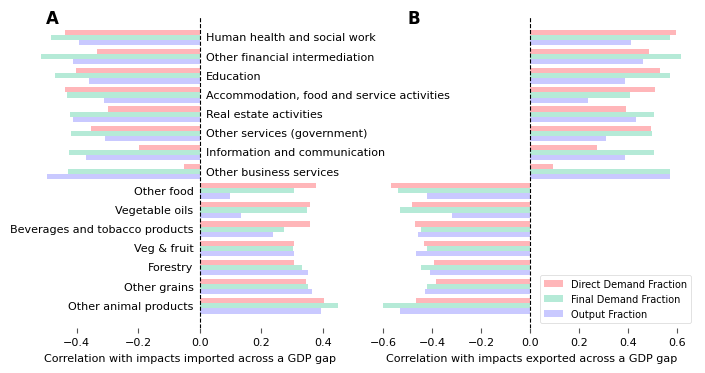

In [ ]:

# Bar plot settings
bar_width = 0.27
# colors = ['#1f77b4', '#ff7f0e', '#d62728']
colors = ['#FFB6B9',  # Strawberry pink
          '#B5EAD7',  # Mint green
          '#C9C9FF']  # Lavender
labels_G50_gtap = ['G50_direct_demand_gtap', 'G50_final_demand_gtap', 'G50_output_gtap']
labels_L50_gtap = ['L50_direct_demand_gtap', 'L50_final_demand_gtap', 'L50_output_gtap']

fig, axes = plt.subplots(1, 2, figsize=(7, 7*8/14), sharey=True)
fig.subplots_adjust(wspace=-1.0)

# Add vertical line between panels (in figure coordinates)
#line_x = 0.622  # halfway between the two subplots
#fig.lines.append(plt.Line2D([line_x, line_x], [0.1, 0.9], transform=fig.transFigure, color='black', linewidth=1))


# Plot left panel: G50
y_pos_G50 = np.arange(len(sorted_G50_gtap))
bar_handles = []
for i, col in enumerate(labels_G50_gtap):
    bars = axes[0].barh(y_pos_G50 + (i - 1) * bar_width, sorted_G50_gtap[col], height=bar_width, color=colors[i])
    bar_handles.append(bars[0])  # Only use one for legend
    if i == 2: # Add custom tick labels.
      labels = sorted_G50_gtap['Sector Description']
      values = sorted_G50_gtap[col]
      for bar, label, value in zip(bars, labels, values):
        y = bar.get_y() - bar.get_height() / 2
        if value >= 0:
          x = -0.02  # small offset to the right
          ha = 'right'
        else:
          x = 0.02  # small offset to the left
          ha = 'left'
        axes[0].text(x, y, label, va='center', ha=ha, fontsize=8)

axes[0].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].text(-.5, -.75, "A",fontsize=12,fontweight='bold')
axes[0].set_xlabel("Correlation with impacts imported across a GDP gap", fontsize=8, color='black')
axes[0].set_yticks(y_pos_G50)
axes[0].set_yticklabels([])
axes[0].invert_yaxis()
axes[0].tick_params(axis='y', which='both', length=0)

# Plot right panel: L50
y_pos_L50 = np.arange(len(sorted_L50_gtap))
for i, col in enumerate(labels_L50_gtap):
    axes[1].barh(y_pos_L50 + (i - 1) * bar_width, sorted_L50_gtap[col], height=bar_width, color=colors[i])

axes[1].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].text(-.5, -.75, "B",fontsize=12,fontweight='bold')
axes[1].set_xlabel("Correlation with impacts exported across a GDP gap", fontsize=8, color='black')
axes[1].tick_params(axis='y', which='both', length=0)
# Don't call set_yticks again later — that would override it.
# axes[1].set_yticks(y_pos_L50)
# axes[1].set_yticklabels(sorted_L50_gtap['Sector Description'],fontsize=12)  # Hide tick labels on right panel
# Set white background for figure and both subplots
fig.patch.set_facecolor('white')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')
axes[0].grid(False)
axes[1].grid(False)
axes[0].tick_params(axis='x', which='both', labelsize=8, labelcolor='black')
axes[1].tick_params(axis='x', which='both', labelsize=8, labelcolor='black')


for spine in axes[1].spines.values():
    spine.set_visible(False)
for spine in axes[0].spines.values():
    spine.set_visible(False)

labels_names = ['Direct Demand Fraction','Final Demand Fraction','Output Fraction']
# Shared legend using handles
# fig.legend(bar_handles, labels_names, loc='upper center', ncol=3, fontsize=14)

# Shared legend with white background
legend = axes[1].legend(bar_handles, labels_names, loc='lower right', ncol=1, fontsize=7, frameon=True)
legend.get_frame().set_facecolor('none')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("First_review_plot/Fig4_GTAP.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# All sectors
unfiltered_corr_gtap = combined_corr_gtap[combined_corr_gtap['abs_average_corr'] > 0].copy()

# Sort sectors: negative values on top, positive on bottom
unfiltered_corr_gtap['G50_mean'] = unfiltered_corr_gtap[['G50_direct_demand_gtap', 'G50_final_demand_gtap', 'G50_output_gtap']].mean(axis=1)
unfiltered_corr_gtap['L50_mean'] = unfiltered_corr_gtap[['L50_direct_demand_gtap', 'L50_final_demand_gtap', 'L50_output_gtap']].mean(axis=1)
sorted_G50_gtap = unfiltered_corr_gtap.sort_values('G50_mean')
sorted_G50_gtap['Sector Description'] = sorted_G50_gtap['Sector Description'].astype(str)
sorted_L50_gtap = unfiltered_corr_gtap.sort_values('L50_mean',ascending=False)
# Extract the desired order from sorted_G50
sector_order_gtap = sorted_G50_gtap['Sector Description'].tolist()

# Apply this order to sorted_L50 using Categorical sorting
sorted_L50_gtap = sorted_L50_gtap.copy()
sorted_L50_gtap['Sector Description'] = pd.Categorical(
    sorted_L50_gtap['Sector Description'],
    categories=sector_order_gtap,
    ordered=True
)

# Sort by the new categorical order
sorted_L50_gtap = sorted_L50_gtap.sort_values('Sector Description')

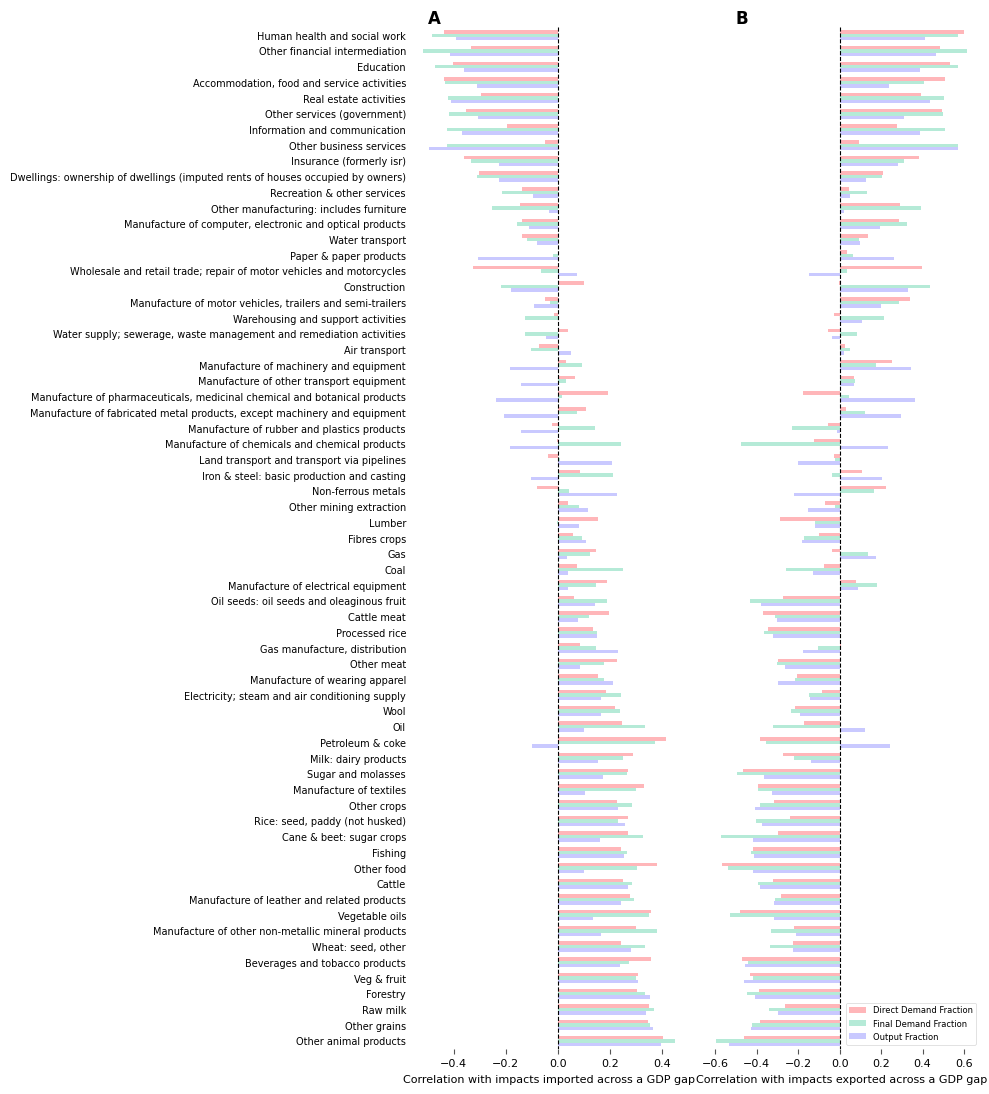

In [ ]:
# def split_label(label):
#     parts = label.split()
#     if len(parts) <= 2:
#         return label  # leave short labels unchanged
#     mid = len(parts) // 2
#     return ' '.join(parts[:mid]) + '\n' + ' '.join(parts[mid:])
# def split_label(label):
#     parts = label.split()
#     if len(label) <= 25 or len(parts) <= 3:
#         return label  # keep short labels as one line
#     mid = len(parts) // 2
#     return ' '.join(parts[:mid]) + '\n' + ' '.join(parts[mid:])


# Bar plot settings
bar_width = 0.22
# colors = ['#1f77b4', '#ff7f0e', '#d62728']
colors = ['#FFB6B9',  # Strawberry pink
          '#B5EAD7',  # Mint green
          '#C9C9FF']  # Lavender
labels_G50_gtap = ['G50_direct_demand_gtap', 'G50_final_demand_gtap', 'G50_output_gtap']
labels_L50_gtap = ['L50_direct_demand_gtap', 'L50_final_demand_gtap', 'L50_output_gtap']

fig, axes = plt.subplots(1, 2, figsize=(10, 11.5), sharey=True)
fig.subplots_adjust(wspace=-1.0)

# Add vertical line between panels (in figure coordinates)
#line_x = 0.622  # halfway between the two subplots
#fig.lines.append(plt.Line2D([line_x, line_x], [0.1, 0.9], transform=fig.transFigure, color='black', linewidth=1))


# Plot left panel: G50
y_pos_G50 = np.arange(len(sorted_G50_gtap))
bar_handles = []
for i, col in enumerate(labels_G50_gtap):
    bars = axes[0].barh(y_pos_G50 + (i - 1) * bar_width, sorted_G50_gtap[col], height=bar_width, color=colors[i])
    bar_handles.append(bars[0])  # Only use one for legend
#     if i == 2: # Add custom tick labels.
#       labels = sorted_G50_gtap['Sector Description']
#       values = sorted_G50_gtap[col]
#       for bar, label, value in zip(bars, labels, values):
#         y = bar.get_y() - bar.get_height() / 2
#         if value >= 0:
#           x = -0.02  # small offset to the right
#           ha = 'left'
#         else:
#           x = -0.02  # small offset to the left
#           ha = 'left'
#         axes[0].text(x, y, label, va='center', ha=ha, fontsize=8)

# axes[0].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].vlines(x=0, ymin=-0.5, ymax=len(y_pos_G50)-0.5, color='black', linewidth=0.8, linestyle='--')
axes[0].text(-.5, -.75, "A",fontsize=12,fontweight='bold')
axes[0].set_xlabel("Correlation with impacts imported across a GDP gap", fontsize=8, color='black')
axes[0].set_yticks(y_pos_G50)
# formatted_labels = [split_label(l) for l in sorted_G50_gtap['Sector Description']]
# axes[0].set_yticklabels(formatted_labels, fontsize=7, color='black')
axes[0].set_yticklabels(sorted_G50_gtap['Sector Description'],fontsize=7,color='black')
axes[0].invert_yaxis()
axes[0].set_ylim(len(y_pos_G50) - 0.5, -0.5)
# axes[1].set_ylim(len(y_pos_L50) - 0.5, -0.5)
axes[0].tick_params(axis='y', which='both', length=0)

# Plot right panel: L50
y_pos_L50 = np.arange(len(sorted_L50_gtap))
for i, col in enumerate(labels_L50_gtap):
    axes[1].barh(y_pos_L50 + (i - 1) * bar_width, sorted_L50_gtap[col], height=bar_width, color=colors[i])

# axes[1].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].vlines(x=0, ymin=-0.5, ymax=len(y_pos_L50)-0.5, color='black', linewidth=0.8, linestyle='--')
axes[1].text(-.5, -.75, "B",fontsize=12,fontweight='bold')
axes[1].set_xlabel("Correlation with impacts exported across a GDP gap", fontsize=8, color='black')
axes[1].tick_params(axis='y', which='both', length=0)
# Don't call set_yticks again later — that would override it.
# axes[1].set_yticks(y_pos_L50)
# axes[1].set_yticklabels(sorted_L50_gtap['Sector Description'],fontsize=12)  # Hide tick labels on right panel
# Set white background for figure and both subplots
fig.patch.set_facecolor('white')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')
axes[0].grid(False)
axes[1].grid(False)
axes[0].tick_params(axis='x', which='both', labelsize=8, labelcolor='black')
axes[1].tick_params(axis='x', which='both', labelsize=8, labelcolor='black')


for spine in axes[1].spines.values():
    spine.set_visible(False)
for spine in axes[0].spines.values():
    spine.set_visible(False)

labels_names = ['Direct Demand Fraction','Final Demand Fraction','Output Fraction']
# Shared legend using handles
# fig.legend(bar_handles, labels_names, loc='upper center', ncol=3, fontsize=14)

# Shared legend with white background
legend = axes[1].legend(bar_handles, labels_names, loc='lower right', ncol=1, fontsize=6, frameon=True)

legend.get_frame().set_facecolor('none')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("First_review_plot/Fig4_GTAP2.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()



# 2. EORA

In [ ]:
# @title Read files
# population

# We only care about the country sequence
file = open("Data/Total_pop.json", "r")
population2 = file.read()
population2 = json.loads(population2)
Countries = list(population2.keys())

file = open("Data/Total_pop_eora.json", "r")
population_eora = file.read()
population_eora = json.loads(population_eora)
population_eora = {k: population_eora[k] for k in Countries}

file = open("Data/S4.json", "r")
con_mort_tol_eora = file.read()
con_mort_tol_eora = json.loads(con_mort_tol_eora)

# Row sum: total deaths happen in that country
con_total_eora = dict(pd.DataFrame(con_mort_tol_eora).sum(axis = 1))

# Col sum: total deaths caused by that country
con_caused_eora = dict(pd.DataFrame(con_mort_tol_eora).sum(axis = 0))

file = open("Data/final_demand_eora.json", "r")
final_demand_eora = file.read()
final_demand_eora = json.loads(final_demand_eora)

# GTAP is in 1000000 USD
for i in final_demand_eora:
    final_demand_eora[i] = final_demand_eora[i] * 1000000

demand_capita_eora = {}
for country in population_eora:
    if population_eora[country] == 0:
        demand_capita_eora[country] = 0
    else:
        demand_capita_eora[country] = final_demand_eora[country] / population_eora[country]

In [ ]:
# @title 2.1 Calculation 1: Fraction of deaths caused by foreign demand and occur in the current country
# deaths happen in that country caused by foreign demand
death_by_allforeigndemand_eora = {} # deaths caused by all foreign demand
death_by_G50foreigndemand_eora = {} # deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
death_by_G100foreigndemand_eora = {} # deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
for i in demand_capita_eora:
    death_by_allforeigndemand_eora[i] = 0
    death_by_G50foreigndemand_eora[i] = 0
    death_by_G100foreigndemand_eora[i] = 0
    for j in demand_capita_eora:
        if i != j:
            death_by_allforeigndemand_eora[i] += con_mort_tol_eora[j][i] # deaths caused by j and happen in i

            if demand_capita_eora[j] >= 1.5 * demand_capita_eora[i]:
                death_by_G50foreigndemand_eora[i] += con_mort_tol_eora[j][i]

            if demand_capita_eora[j] >= 2 * demand_capita_eora[i]:
                death_by_G100foreigndemand_eora[i] += con_mort_tol_eora[j][i]

# total deaths happen in that country
con_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_dom_world_eora[country] = {}
    con_dom_world_eora[country]['domestic'] = con_mort_tol_eora[country][country]
    con_dom_world_eora[country]['world'] = con_total_eora[country]
    con_dom_world_eora[country]['OtherPartofWorld'] = con_dom_world_eora[country]['world'] - con_dom_world_eora[country]['domestic']

# total deaths happen in that country RATIO
allforeign_world_eora = {}
G50foreign_world_eora = {}
G100foreign_world_eora = {}
for country in con_dom_world_eora:
    if con_dom_world_eora[country]['world'] != 0:
        allforeign_world_eora[country] = death_by_allforeigndemand_eora[country] / con_dom_world_eora[country]['world']
        G50foreign_world_eora[country] = death_by_G50foreigndemand_eora[country] / con_dom_world_eora[country]['world']
        G100foreign_world_eora[country] = death_by_G100foreigndemand_eora[country] / con_dom_world_eora[country]['world']
    else:
        allforeign_world_eora[country] = 0
        G50foreign_world_eora[country] = 0
        G100foreign_world_eora[country] = 0

In [ ]:
# @title 2.2 Calculation 2: Fraction of deaths caused by consumption in this country that occur in other countries
# deaths caused by this country and happen in foreign country
death_allforeign_eora = {} # deaths caused by consumption in this country that occur in ALL other countries
death_L30foreigndemand_eora = {} # deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
death_L50foreigndemand_eora = {} # deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country

for i in con_mort_tol_eora:
    death_allforeign_eora[i] = 0
    death_L30foreigndemand_eora[i] = 0
    death_L50foreigndemand_eora[i] = 0
    for j in con_mort_tol_eora:
        if i != j:
            death_allforeign_eora[i] += con_mort_tol_eora[i][j] # deaths caused by i and happen in j

            if demand_capita_eora[j] <= 0.7 * demand_capita_eora[i]:
                death_L30foreigndemand_eora[i] += con_mort_tol_eora[i][j]

            if demand_capita_eora[j] <= 0.5 * demand_capita_eora[i]:
                death_L50foreigndemand_eora[i] += con_mort_tol_eora[i][j]

# total deaths caused by that country
con_cause_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_cause_dom_world_eora[country] = {}
    con_cause_dom_world_eora[country]['domestic'] = con_mort_tol_eora[country][country]
    con_cause_dom_world_eora[country]['world'] = con_caused_eora[country]
    con_cause_dom_world_eora[country]['OtherPartofWorld'] = con_cause_dom_world_eora[country]['world'] - con_cause_dom_world_eora[country]['domestic']

# total deaths caused by that country RATIO
cause_allforeign_world_eora = {}
cause_L30foreign_world_eora = {}
cause_L50foreign_world_eora = {}
for country in con_cause_dom_world_eora:
    if con_cause_dom_world_eora[country]['world'] != 0:
        cause_allforeign_world_eora[country] = death_allforeign_eora[country] / con_cause_dom_world_eora[country]['world']
        cause_L30foreign_world_eora[country] = death_L30foreigndemand_eora[country] / con_cause_dom_world_eora[country]['world']
        cause_L50foreign_world_eora[country] = death_L50foreigndemand_eora[country] / con_cause_dom_world_eora[country]['world']
    else:
        cause_allforeign_world_eora[country] = 0
        cause_L30foreign_world_eora[country] = 0
        cause_L50foreign_world_eora[country] = 0

In [ ]:
#@title 2.3 Calculation 3: Net export of deaths
# Row sum: total deaths happen in that country
con_total_eora = dict(pd.DataFrame(con_mort_tol_eora).sum(axis=1))

# Col sum: total deaths caused by that country
con_caused_eora = dict(pd.DataFrame(con_mort_tol_eora).sum(axis=0))

# total deaths happen in that country
con_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_dom_world_eora[country] = {}
    con_dom_world_eora[country]['domestic'] = float(con_mort_tol_eora[country][country])
    con_dom_world_eora[country]['world'] = float(con_total_eora[country])
    con_dom_world_eora[country]['OtherPartofWorld'] = con_dom_world_eora[country]['world'] - con_dom_world_eora[country]['domestic']

# total deaths caused by that country
con_cause_dom_world_eora = {}
for country in con_mort_tol_eora:
    con_cause_dom_world_eora[country] = {}
    con_cause_dom_world_eora[country]['domestic'] = float(con_mort_tol_eora[country][country])
    con_cause_dom_world_eora[country]['world'] = float(con_caused_eora[country])
    con_cause_dom_world_eora[country]['OtherPartofWorld'] = con_cause_dom_world_eora[country]['world'] - con_cause_dom_world_eora[country]['domestic']

net_export_death_eora = {}
export_of_death_eora = {}
import_of_death_eora = {}

for country in con_cause_dom_world_eora:
  # net export of deaths
  net_export_death_eora[country] = (con_cause_dom_world_eora[country]['OtherPartofWorld'] - con_dom_world_eora[country]['OtherPartofWorld'])


net_export_death_per_eora = {} # per population

for country in con_cause_dom_world_eora:
  if country != 'XTW':
    net_export_val_eora = (con_cause_dom_world_eora[country]['OtherPartofWorld'] - con_dom_world_eora[country]['OtherPartofWorld'])/(population_eora[country]/10000)
    net_export_death_per_eora[country] = net_export_val_eora
  else:
    net_export_death_per_eora[country] = 0

In [ ]:
# reorder the dependent variables so that their sequence can confirm with the output fracton matrix
allforeign_world_eora = list(allforeign_world_eora.values())[:-1]
G50foreign_world_eora =  list(G50foreign_world_eora.values())[:-1]
G100foreign_world_eora =  list(G100foreign_world_eora.values())[:-1]

cause_allforeign_world_eora =  list(cause_allforeign_world_eora.values())[:-1]
cause_L30foreign_world_eora =  list(cause_L30foreign_world_eora.values())[:-1]
cause_L50foreign_world_eora =  list(cause_L50foreign_world_eora.values())[:-1]


net_export_death_per_eora =  list({k: net_export_death_per_eora[k] for k in final_demand_eora}.values())[:-1]
net_export_death_eora =  list({k: net_export_death_eora[k] for k in final_demand_eora}.values())[:-1]

## Output fraction

In [ ]:
output_fraction_eora = pd.read_csv('Data/output_fraction_eora.csv',index_col=0)

eora_sectors = output_fraction_eora.columns

dependent_eora = ['allforeign_world_eora','G50foreign_world_eora','G100foreign_world_eora','cause_allforeign_world_eora','cause_L30foreign_world_eora','cause_L50foreign_world_eora','net_export_death_eora','net_export_death_per_eora']

# deaths caused by all foreign demand
output_fraction_eora['allforeign_world_eora'] = allforeign_world_eora
# deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
output_fraction_eora['G50foreign_world_eora'] = G50foreign_world_eora
 # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
output_fraction_eora['G100foreign_world_eora'] = G100foreign_world_eora

# deaths caused by consumption in this country that occur in ALL other countries
output_fraction_eora['cause_allforeign_world_eora'] = cause_allforeign_world_eora
# deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
output_fraction_eora['cause_L30foreign_world_eora'] = cause_L30foreign_world_eora
# deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country
output_fraction_eora['cause_L50foreign_world_eora'] = cause_L50foreign_world_eora


output_fraction_eora['net_export_death_eora'] = net_export_death_eora
output_fraction_eora['net_export_death_per_eora'] = net_export_death_per_eora


# List to store results
r_squared_values_eora = []

# Iterate over each column x
for x_col in eora_sectors:
    # Iterate over each column y
    for y_col in dependent_eora:
        # Calculate Pearson correlation coefficient and R-squared
        pearson_corr, _ = pearsonr(output_fraction_eora[x_col], output_fraction_eora[y_col])
        r_squared = pearson_corr ** 2
        # Append the R-squared value to the list
        r_squared_values_eora.append((x_col, y_col, pearson_corr, r_squared))

# Convert the list of tuples to a DataFrame
r_squared_df_eora = pd.DataFrame(r_squared_values_eora, columns=['X_Column', 'Y_Column','Pearson Correlation', 'R_Squared'])

In [ ]:
r_squared_df_eora.sort_values(by='Pearson Correlation', ascending=True)[:5]

,X_Column,Y_Column,Pearson Correlation,R_Squared
4,Agriculture,cause_L30foreign_world_eora,-0.575822,0.331571
5,Agriculture,cause_L50foreign_world_eora,-0.559589,0.313140
27,Food & Beverages,cause_allforeign_world_eora,-0.333422,0.111170
178,"Education, Health and Other Services",G100foreign_world_eora,-0.299880,0.089928
62,Metal Products,net_export_death_eora,-0.280819,0.078860


In [ ]:
output_corr_eora = r_squared_df_eora.pivot(index='X_Column', columns='Y_Column', values='Pearson Correlation')
# multiply by negative 1, and calculate the average and sort them. "G50foreign_world_eora", "cause_L50foreign_world_eora","net_export_death_per_eora"
output_corr_eora = output_corr_eora[['G50foreign_world_eora','cause_L50foreign_world_eora']] # 'net_export_death_per_eora'
output_corr_eora['abs_average_corr'] = output_corr_eora[['G50foreign_world_eora',
                         'cause_L50foreign_world_eora']].abs().mean(axis=1)

output_corr_eora = output_corr_eora.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
output_corr_eora

Y_Column,G50foreign_world_eora,cause_L50foreign_world_eora,abs_average_corr
X_Column,,,
Agriculture,0.487628,-0.559589,0.523609
"Education, Health and Other Services",-0.279864,0.402646,0.341255
Finacial Intermediation and Business Activities,-0.254955,0.395962,0.325458
"Electricity, Gas and Water",0.219239,-0.172007,0.195623
Transport,-0.183936,0.202028,0.192982
Re-export & Re-import,-0.160081,0.211977,0.186029
Post and Telecommunications,0.242359,-0.120514,0.181436
Fishing,0.156449,-0.181630,0.169040
Electrical and Machinery,-0.115768,0.217670,0.166719


## Direct Demand Fraction

In [ ]:
D_demand_fraction_eora = pd.read_csv('First_review_data/Direct_fd_fraction_eora.csv',index_col=0)

In [ ]:
eora_sectors = D_demand_fraction_eora.columns

In [ ]:
eora_sectors = D_demand_fraction_eora.columns
# deaths caused by all foreign demand
D_demand_fraction_eora['allforeign_world_eora'] = allforeign_world_eora
# deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
D_demand_fraction_eora['G50foreign_world_eora'] = G50foreign_world_eora
 # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
D_demand_fraction_eora['G100foreign_world_eora'] = G100foreign_world_eora

# deaths caused by consumption in this country that occur in ALL other countries
D_demand_fraction_eora['cause_allforeign_world_eora'] = cause_allforeign_world_eora
# deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
D_demand_fraction_eora['cause_L30foreign_world_eora'] = cause_L30foreign_world_eora
# deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country
D_demand_fraction_eora['cause_L50foreign_world_eora'] = cause_L50foreign_world_eora


D_demand_fraction_eora['net_export_death_eora'] = net_export_death_eora
D_demand_fraction_eora['net_export_death_per_eora'] = net_export_death_per_eora

# List to store results
r_squared_values_eora = []

# Iterate over each column x
for x_col in eora_sectors:
    # Iterate over each column y
    for y_col in dependent_eora:
        # Calculate Pearson correlation coefficient and R-squared
        pearson_corr, _ = pearsonr(D_demand_fraction_eora[x_col], D_demand_fraction_eora[y_col])
        r_squared = pearson_corr ** 2
        # Append the R-squared value to the list
        r_squared_values_eora.append((x_col, y_col, pearson_corr, r_squared))

# Convert the list of tuples to a DataFrame
r_squared_ddemand_df_eora = pd.DataFrame(r_squared_values_eora, columns=['X_Column', 'Y_Column','Pearson Correlation', 'R_Squared'])

In [ ]:
r_squared_ddemand_df_eora.sort_values(by='Pearson Correlation', ascending=True)[:5]

,X_Column,Y_Column,Pearson Correlation,R_Squared
4,Agriculture,cause_L30foreign_world_eora,-0.466685,0.217795
5,Agriculture,cause_L50foreign_world_eora,-0.448457,0.201114
178,"Education, Health and Other Services",G100foreign_world_eora,-0.404192,0.163371
177,"Education, Health and Other Services",G50foreign_world_eora,-0.380051,0.144439
27,Food & Beverages,cause_allforeign_world_eora,-0.335796,0.112759


In [ ]:
demand_corr_eora = r_squared_ddemand_df_eora.pivot(index='X_Column', columns='Y_Column', values='Pearson Correlation')
demand_corr_eora.index = demand_corr_eora.index.str.strip()
# multiply by negative 1, and calculate the average and sort them. "G50foreign_world_eora", "cause_L50foreign_world_eora","net_export_death_per_eora"
demand_corr_eora = demand_corr_eora[['G50foreign_world_eora','cause_L50foreign_world_eora']] # 'net_export_death_per_eora'
demand_corr_eora['abs_average_corr'] = demand_corr_eora[['G50foreign_world_eora',
                         'cause_L50foreign_world_eora',]].abs().mean(axis=1)



demand_corr_eora = demand_corr_eora.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
demand_corr_eora

Y_Column,G50foreign_world_eora,cause_L50foreign_world_eora,abs_average_corr
X_Column,,,
"Education, Health and Other Services",-0.380051,0.512330,0.446191
Agriculture,0.316301,-0.448457,0.382379
Finacial Intermediation and Business Activities,-0.309778,0.304762,0.307270
Post and Telecommunications,0.292788,-0.318659,0.305723
Public Administration,-0.178127,0.348992,0.263559
Fishing,0.177282,-0.316447,0.246865
"Petroleum, Chemical and Non-Metallic Mineral Products",0.262525,-0.212879,0.237702
Recycling,0.259906,-0.166384,0.213145
"Electricity, Gas and Water",0.205151,-0.164157,0.184654


## Indirect Demand Fraction

In [ ]:
In_demand_fraction_eora = pd.read_csv('First_review_data/Indirect_fd_fraction_eora.csv',index_col=0)

eora_sectors = In_demand_fraction_eora.columns

# deaths caused by all foreign demand
In_demand_fraction_eora['allforeign_world_eora'] = allforeign_world_eora
# deaths caused by demand from countries where demand/capita is >50% more than demand/capita in current country
In_demand_fraction_eora['G50foreign_world_eora'] = G50foreign_world_eora
 # deaths caused by demand from countries where demand/capita is >100% more than demand/capita in current country
In_demand_fraction_eora['G100foreign_world_eora'] = G100foreign_world_eora

# deaths caused by consumption in this country that occur in ALL other countries
In_demand_fraction_eora['cause_allforeign_world_eora'] = cause_allforeign_world_eora
# deaths caused by consumption in this country that occur in countries with >33% lower demand/capita than the current country
In_demand_fraction_eora['cause_L30foreign_world_eora'] = cause_L30foreign_world_eora
# deaths caused by consumption in this country that occur in countries with >50% lower demand/capita than the current country
In_demand_fraction_eora['cause_L50foreign_world_eora'] = cause_L50foreign_world_eora


In_demand_fraction_eora['net_export_death_eora'] = net_export_death_eora
In_demand_fraction_eora['net_export_death_per_eora'] = net_export_death_per_eora

# List to store results
r_squared_values_eora = []

# Iterate over each column x
for x_col in eora_sectors:
    # Iterate over each column y
    for y_col in dependent_eora:
        # Calculate Pearson correlation coefficient and R-squared
        pearson_corr, _ = pearsonr(In_demand_fraction_eora[x_col], In_demand_fraction_eora[y_col])
        r_squared = pearson_corr ** 2
        # Append the R-squared value to the list
        r_squared_values_eora.append((x_col, y_col, pearson_corr, r_squared))

# Convert the list of tuples to a DataFrame
r_squared_indemand_df_eora = pd.DataFrame(r_squared_values_eora, columns=['X_Column', 'Y_Column','Pearson Correlation', 'R_Squared'])

In [ ]:
r_squared_indemand_df_eora.sort_values(by='Pearson Correlation', ascending=True)[:5]

,X_Column,Y_Column,Pearson Correlation,R_Squared
4,Agriculture,cause_L30foreign_world_eora,-0.504132,0.254149
5,Agriculture,cause_L50foreign_world_eora,-0.493781,0.243820
178,"Education, Health and Other Services",G100foreign_world_eora,-0.440800,0.194305
177,"Education, Health and Other Services",G50foreign_world_eora,-0.429716,0.184656
12,Fishing,cause_L30foreign_world_eora,-0.350901,0.123132


In [ ]:
in_demand_corr_eora = r_squared_indemand_df_eora.pivot(index='X_Column', columns='Y_Column', values='Pearson Correlation')
in_demand_corr_eora.index = in_demand_corr_eora.index.str.strip()
# multiply by negative 1, and calculate the average and sort them. "G50foreign_world_eora", "cause_L50foreign_world_eora","net_export_death_per_eora"
in_demand_corr_eora = in_demand_corr_eora[['G50foreign_world_eora','cause_L50foreign_world_eora']] # 'net_export_death_per_eora'
in_demand_corr_eora['abs_average_corr'] = in_demand_corr_eora[['G50foreign_world_eora',
                         'cause_L50foreign_world_eora']].abs().mean(axis=1)

in_demand_corr_eora = in_demand_corr_eora.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
in_demand_corr_eora

Y_Column,G50foreign_world_eora,cause_L50foreign_world_eora,abs_average_corr
X_Column,,,
"Education, Health and Other Services",-0.429716,0.493499,0.461607
Agriculture,0.331933,-0.493781,0.412857
Finacial Intermediation and Business Activities,-0.261303,0.396143,0.328723
"Petroleum, Chemical and Non-Metallic Mineral Products",0.224705,-0.280389,0.252547
Fishing,0.148688,-0.338276,0.243482
Public Administration,-0.186706,0.284832,0.235769
Recycling,0.201061,-0.191205,0.196133
"Electricity, Gas and Water",0.204783,-0.152425,0.178604
Construction,-0.233844,0.086195,0.160019


## Combine these three correlations and calculate the average --EORA

In [ ]:
# Drop unwanted column and rename columns for distinction
demand_renamed_eora = demand_corr_eora.drop(columns='abs_average_corr').rename(columns={
    'G50foreign_world_eora': 'G50_direct_demand_eora',
    'cause_L50foreign_world_eora': 'L50_direct_demand_eora'
})

in_demand_renamed_eora = in_demand_corr_eora.drop(columns='abs_average_corr').rename(columns={
    'G50foreign_world_eora': 'G50_final_demand_eora',
    'cause_L50foreign_world_eora': 'L50_final_demand_eora'
})

output_renamed_eora = output_corr_eora.drop(columns='abs_average_corr').rename(columns={
    'G50foreign_world_eora': 'G50_output_eora',
    'cause_L50foreign_world_eora': 'L50_output_eora'
})

demand_renamed_eora.reset_index(inplace=True)
in_demand_renamed_eora.reset_index(inplace=True)
output_renamed_eora.reset_index(inplace=True)
# Merge the DataFrames on 'X_Column'
combined_corr_eora = demand_renamed_eora.merge(in_demand_renamed_eora, on='X_Column')
combined_corr_eora = combined_corr_eora.merge(output_renamed_eora, on='X_Column')

In [ ]:
combined_corr_eora['abs_average_corr'] = combined_corr_eora[['G50_direct_demand_eora','L50_direct_demand_eora',
                                                   'G50_final_demand_eora','L50_final_demand_eora',
                                                   'G50_output_eora','L50_output_eora']].abs().mean(axis=1)

combined_corr_eora = combined_corr_eora.sort_values(by='abs_average_corr', ascending=False)

In [ ]:
# Filter sectors with abs_average_corr > 0.35
filtered_corr_eora = combined_corr_eora[combined_corr_eora['abs_average_corr'] > 0].copy()

# Sort sectors: negative values on top, positive on bottom
filtered_corr_eora['G50_mean'] = filtered_corr_eora[['G50_direct_demand_eora', 'G50_final_demand_eora', 'G50_output_eora']].mean(axis=1)
filtered_corr_eora['L50_mean'] = filtered_corr_eora[['L50_direct_demand_eora', 'L50_final_demand_eora', 'L50_output_eora']].mean(axis=1)
sorted_G50_eora = filtered_corr_eora.sort_values('G50_mean')
sorted_G50_eora['X_Column'] = sorted_G50_eora['X_Column'].astype(str)
sorted_L50_eora = filtered_corr_eora.sort_values('L50_mean',ascending=False)
# Extract the desired order from sorted_G50
sector_order_eora = sorted_G50_eora['X_Column'].tolist()

# Apply this order to sorted_L50 using Categorical sorting
sorted_L50_eora = sorted_L50_eora.copy()
sorted_L50_eora['X_Column'] = pd.Categorical(
    sorted_L50_eora['X_Column'],
    categories=sector_order_eora,
    ordered=True
)

# Sort by the new categorical order
sorted_L50_eora = sorted_L50_eora.sort_values('X_Column')

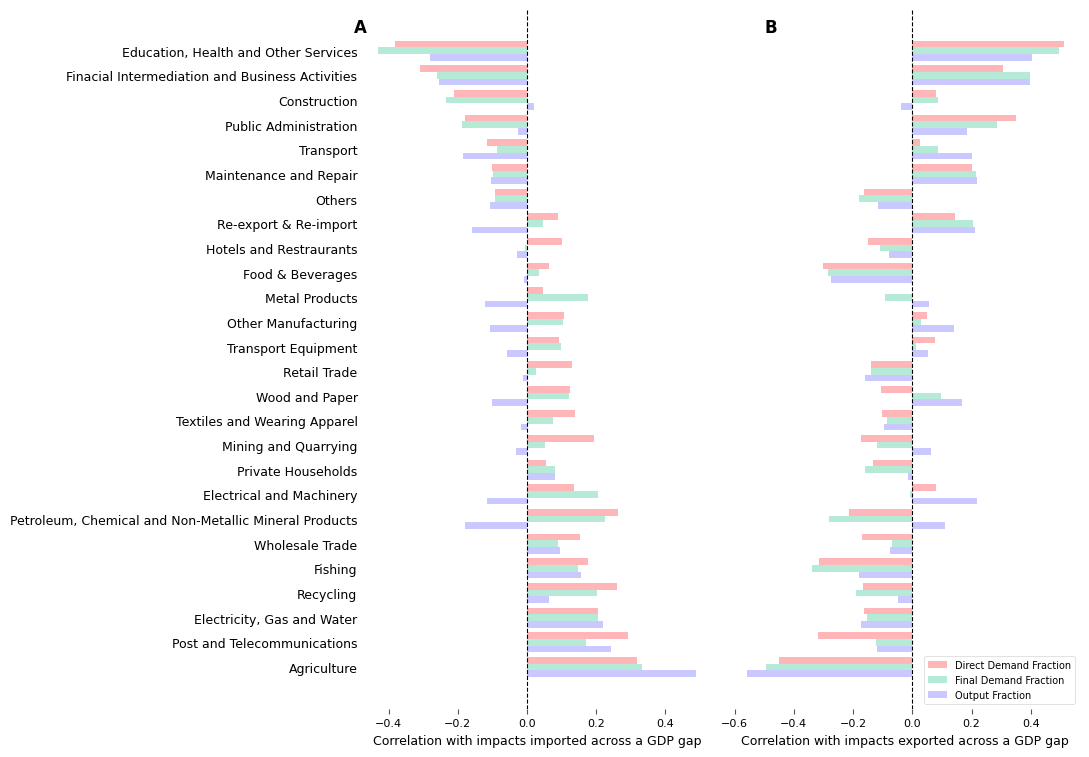

In [ ]:

# Bar plot settings
bar_width = 0.27
# colors = ['#1f77b4', '#ff7f0e', '#d62728']
colors = ['#FFB6B9',  # Strawberry pink
          '#B5EAD7',  # Mint green
          '#C9C9FF']  # Lavender
labels_G50_eora = ['G50_direct_demand_eora', 'G50_final_demand_eora', 'G50_output_eora']
labels_L50_eora = ['L50_direct_demand_eora', 'L50_final_demand_eora', 'L50_output_eora']

fig, axes = plt.subplots(1, 2, figsize=(11,8), sharey=True)
fig.subplots_adjust(wspace=-1.0)

# Add vertical line between panels (in figure coordinates)
#line_x = 0.622  # halfway between the two subplots
#fig.lines.append(plt.Line2D([line_x, line_x], [0.1, 0.9], transform=fig.transFigure, color='black', linewidth=1))


# Plot left panel: G50
y_pos_G50 = np.arange(len(sorted_G50_eora))
bar_handles = []
for i, col in enumerate(labels_G50_eora):
    bars = axes[0].barh(y_pos_G50 + (i - 1) * bar_width, sorted_G50_eora[col], height=bar_width, color=colors[i])
    bar_handles.append(bars[0])  # Only use one for legend
    # if i == 2: # Add custom tick labels.
    #   labels = sorted_G50_eora['X_Column']
    #   values = sorted_G50_eora[col]
    #   for bar, label, value in zip(bars, labels, values):
    #     y = bar.get_y() - bar.get_height() / 2
    #     if value >= 0:
    #       x = -0.02  # small offset to the right
    #       ha = 'right'
    #     else:
    #       x = 0.02  # small offset to the left
    #       ha = 'left'
    #     axes[0].text(x, y, label, va='center', ha=ha, fontsize=8)

axes[0].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].text(-.5, -.75, "A",fontsize=12,fontweight='bold')
axes[0].set_xlabel("Correlation with impacts imported across a GDP gap", fontsize=9, color='black')
axes[0].set_yticks(y_pos_G50)
axes[0].set_yticklabels(sorted_G50_eora['X_Column'],fontsize=9,color='black')
axes[0].invert_yaxis()
axes[0].tick_params(axis='y', which='both', length=0)

# Plot right panel: L50
y_pos_L50 = np.arange(len(sorted_L50_eora))
for i, col in enumerate(labels_L50_eora):
    axes[1].barh(y_pos_L50 + (i - 1) * bar_width, sorted_L50_eora[col], height=bar_width, color=colors[i])

axes[1].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].text(-.5, -.75, "B",fontsize=12,fontweight='bold')
axes[1].set_xlabel("Correlation with impacts exported across a GDP gap", fontsize=9, color='black')
axes[1].tick_params(axis='y', which='both', length=0)
# Don't call set_yticks again later — that would override it.
# axes[1].set_yticks(y_pos_L50)
# axes[1].set_yticklabels(sorted_L50_eora['Sector Description'],fontsize=12)  # Hide tick labels on right panel
# Set white background for figure and both subplots
fig.patch.set_facecolor('white')
axes[0].set_facecolor('none')
axes[1].set_facecolor('none')
axes[0].grid(False)
axes[1].grid(False)
axes[0].tick_params(axis='x', which='both', labelsize=8, labelcolor='black')
axes[1].tick_params(axis='x', which='both', labelsize=8, labelcolor='black')


for spine in axes[1].spines.values():
    spine.set_visible(False)
for spine in axes[0].spines.values():
    spine.set_visible(False)

labels_names = ['Direct Demand Fraction','Final Demand Fraction','Output Fraction']
# Shared legend using handles
# fig.legend(bar_handles, labels_names, loc='upper center', ncol=3, fontsize=14)

# Shared legend with white background
legend = axes[1].legend(bar_handles, labels_names, loc='lower right', ncol=1, fontsize=7, frameon=True)
legend.get_frame().set_facecolor('none')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("First_review_plot/Fig4_EORA.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:

# # Bar plot settings
# bar_width = 0.2
# # colors = ['#1f77b4', '#ff7f0e', '#d62728']
# colors = ['#FFB6B9',  # Strawberry pink
#           '#B5EAD7',  # Mint green
#           '#C9C9FF']  # Lavender
# labels_G50_eora = ['G50_direct_demand_eora', 'G50_final_demand_eora', 'G50_output_eora']
# labels_L50_eora = ['L50_direct_demand_eora', 'L50_final_demand_eora', 'L50_output_eora']

# fig, axes = plt.subplots(1, 2, figsize=(5, 8), sharey=True)
# fig.subplots_adjust(wspace=0.1)

# # Add vertical line between panels (in figure coordinates)
# line_x = 0.63  # halfway between the two subplots
# fig.lines.append(plt.Line2D([line_x, line_x], [0.1, 0.9], transform=fig.transFigure, color='black', linewidth=1))


# # Plot left panel: G50
# y_pos_G50 = np.arange(len(sorted_G50_eora))
# bar_handles = []
# for i, col in enumerate(labels_G50_eora):
#     bars = axes[0].barh(y_pos_G50 + (i - 1) * bar_width, sorted_G50_eora[col], height=bar_width, color=colors[i])
#     bar_handles.append(bars[0])  # Only use one for legend

# axes[0].axvline(0, color='black', linewidth=0.8, linestyle='--')
# axes[0].set_title("Correlation with impacts caused by 50% higher GDP countries",fontsize=13)
# axes[0].set_xlabel("Correlation coefficient")
# # axes[0].set_yticks(y_pos_G50)
# # axes[0].set_yticklabels(sorted_G50_eora['X_Column'],fontsize=12)
# axes[0].invert_yaxis()

# # Plot right panel: L50
# y_pos_L50 = np.arange(len(sorted_L50_eora))
# for i, col in enumerate(labels_L50_eora):
#     axes[1].barh(y_pos_L50 + (i - 1) * bar_width, sorted_L50_eora[col], height=bar_width, color=colors[i])

# axes[1].axvline(0, color='black', linewidth=0.8, linestyle='--')
# axes[1].set_title("Correlation with causing impacts in 50% lower GDP countries",fontsize=13)
# axes[1].set_xlabel("Correlation coefficient")
# # Don't call set_yticks again later — that would override it.
# axes[1].set_yticks(y_pos_L50)
# axes[1].set_yticklabels(sorted_L50_eora['X_Column'],fontsize=12)  # Hide tick labels on right panel
# # Set white background for figure and both subplots
# fig.patch.set_facecolor('white')
# axes[0].set_facecolor('white')
# axes[1].set_facecolor('white')


# labels_names = ['direct_demand_fraction','final_demand_fraction','output_fraction']
# # Shared legend using handles
# # fig.legend(bar_handles, labels_names, loc='upper center', ncol=3, fontsize=14)

# # Shared legend with white background
# legend = fig.legend(bar_handles, labels_names, loc='upper center', ncol=3, fontsize='large', frameon=True)
# legend.get_frame().set_facecolor('white')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

